In [65]:
%load_ext autoreload
%autoreload 2
import sys

sys.path.insert(0, "../../../scirpy/")

import scirpy as ir
import scanpy as sc
import random
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and prepare data

In [3]:
adata = ir.datasets.wu2020()

wu2020.h5ad: 564MB [03:27, 2.71MB/s]                               


In [4]:
adata = adata[adata.obs["has_tcr"] == "True", :]

#### Call clonotypes based on sequence identity

In [10]:
ir.pp.tcr_neighbors(
    adata, metric="identity", receptor_arms="all", dual_tcr="primary_only", cutoff=0
)

100%|██████████| 5599841/5599841 [00:48<00:00, 116256.73it/s]
Trying to set attribute `.uns` of view, copying.


In [11]:
ir.tl.define_clonotypes(adata)

# Benchmarking scirpy clonotype networks

Assumptions
 * We only consider the case of 'primary only' CDR3 sequences, i.e. exactely one pair of alpha/beta chains per cell. 
 * We simulate unique CDR3 sequences by randomly mutating CDR3 amino acid sequences from Wu et al 2020 (~100k cells with TCRs).
   The resulting sequences might not have the same amino acid distribution as genuine CDR3 sequences, but they have 
   the same length distribution, which is the relevant factor for tcr_dist. 
   
### Length distribution

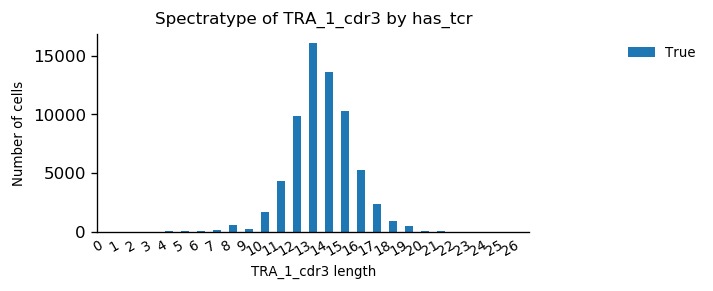

In [12]:
ir.pl.spectratype(adata, cdr3_col="TRA_1_cdr3", color="has_tcr", figsize=(6, 3))

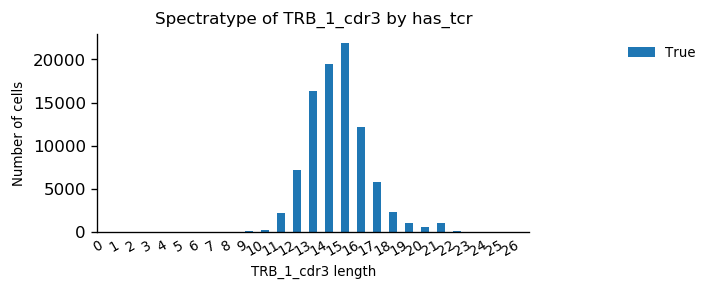

In [13]:
ir.pl.spectratype(adata, cdr3_col="TRB_1_cdr3", color="has_tcr", figsize=(6, 3))

## 1. Benchmark alignment distance
Computing the alignment distance is relatively expensive and quadratic in the number of 
unique CDR3 amino acid sequences. Computing the alignment for each pair of 
CDR3 sequences in quadratic in the length of the sequences. 
By making sure that the simulated sequences follow the same length distribution as
genuine sequences, the benchmark should be representative. 

### Generate a pool of ~1M unique CDR3 sequences 

In [66]:
aas = {
    "V": "VAL",
    "I": "ILE",
    "L": "LEU",
    "E": "GLU",
    "Q": "GLN",
    "D": "ASP",
    "N": "ASN",
    "H": "HIS",
    "W": "TRP",
    "F": "PHE",
    "Y": "TYR",
    "R": "ARG",
    "K": "LYS",
    "S": "SER",
    "T": "THR",
    "M": "MET",
    "A": "ALA",
    "G": "GLY",
    "P": "PRO",
    "C": "CYS",
}
alphabet = np.array(list(aas.keys()))

In [67]:
def mutate(seq):
    """Randomly mutate 1-5 amino acids"""
    try:
        seq = np.array(list(seq))
        n_mut = np.random.randint(0, min(seq.size-1, 6))
        mut_inds = np.unique(np.random.randint(0, seq.size, size=n_mut)), 
        replace_aas = np.random.choice(alphabet, size=len(mut_inds), replace=True)
        seq[mut_inds] = replace_aas
    except:
        print(seq, mut_inds, replace_aas)
        assert False
    return "".join(seq)

In [68]:
random.seed(42)

In [69]:
tras = []
for tra in adata.obs["TRA_1_cdr3"].unique():
    for i in range(40):
        tras.append(mutate(tra))    

In [70]:
tra_uq = np.unique(np.array(tras))

In [71]:
tra_uq.shape

(1006285,)

In [72]:
random.seed(42)

In [73]:
trbs = []
for trb in adata.obs["TRB_1_cdr3"].unique():
    for i in range(40):
        trbs.append(mutate(trb))    

In [74]:
trb_uq = np.unique(np.array(trbs))
trb_uq.shape

(1441065,)

We store a list of 1M unique sequences and subsample it in the runner script. 

In [75]:
pd.DataFrame().assign(tra=tra_uq[:1000000]).to_csv("tmp/1M_cdr3.txt")

## Generate objects for tcr_neighbors

 * The performance of `scirpy.pp.neighbors` is limited by the number of non-negative entries of the cell x cell 
   connectivity matrix. 
 * This number depends on the number of total cells, the fraction of expanded clonotypes and the clonotype sizes. 

In [77]:
n = [5000, 10000, 20000, 40000, 60000, 80000, adata.shape[0]]

In [78]:
top_10_ct_size = []
frac_expanded = []
for i in n:
    tmp_adata = adata.copy()
    sc.pp.subsample(tmp_adata, n_obs=i)
    ir.tl.define_clonotypes(tmp_adata)
    frac_expanded.append(np.sum(tmp_adata.obs["clonotype_size"] >= 2)/ adata.shape[0])
    top_10_ct_size.append(tmp_adata.obs["clonotype_size"].sort_values(ascending=False).unique()[:10])

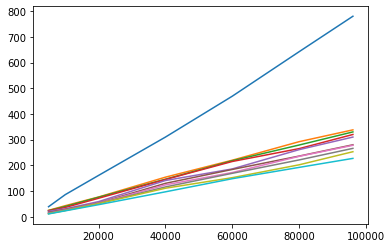

In [79]:
plt.plot(n, [x for x in top_10_ct_size])

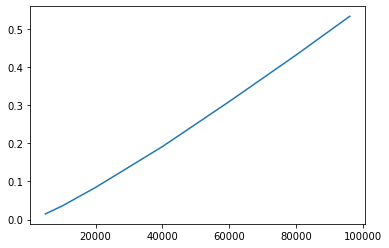

In [80]:
plt.plot(n, frac_expanded)

In [82]:
sc.pp.subsample(tmp_adata, n_obs=5000)

In [83]:
tmp_adata.obs["TRA_1_cdr3"].unique().size

2580